# Tracing

In [17]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16, 14] 

In [18]:
def parse_trace(di, fix = 0):
    trace = pd.DataFrame(columns=["event", "id", "ts", "location"])
    for dirpath, dnames, fnames in os.walk(di):
        for f in fnames:
            if f.endswith(".csv"):
                t = pd.read_csv(os.path.join(dirpath, f), header=None, names=['event', 'id', 'ts'])
                t['location'] =  os.path.splitext(f)[0]
                trace = pd.concat([trace, t])
    trace = trace.set_index("id")
    return trace.apply(pd.to_numeric, errors='ignore')

In [32]:
def delay_between(trace, from_event, to_event, from_location = None, to_location = None):
    data = trace[(trace['event'] == from_event) | (trace['event'] == to_event)]
    joined = trace.join(trace, lsuffix='_from', rsuffix='_to', how='inner')
    filtered = joined[(joined['event_from'] == from_event) & (joined['event_to'] == to_event)]
    if from_location is not None:
        filtered = filtered[filtered['location_from'] == from_location]
    if to_location is not None:
        filtered = filtered[filtered['location_to'] == to_location]
    return np.array((filtered['ts_to'] - filtered['ts_from']).unique(), dtype=np.int64)

In [33]:
def sync_skew(trace):
    for location in trace['location'].unique():
        d = delay_between(trace, 'rear-in', 'barrier-receive', from_location=location)
        if d.size > 0:
            min = d.min()
            trace.loc[trace['location'] == location, 'ts'] += min
    return trace

In [38]:
def stage_plots(trace) :
    bench_in = delay_between(trace, 'bench-send', 'front-receive-send') / 1e6
    plt.plot(np.linspace(0, 1, np.size(bench_in)), np.sort(bench_in), label="bench - front (network)")

    to_source = delay_between(trace, 'front-receive-send', 'flatmap-receive') / 1e6
    plt.plot(np.linspace(0, 1, np.size(to_source)), np.sort(to_source), label="front - source (queue)")
    
    gm_q = delay_between(trace, 'flatmap-send', 'grouping-receive') / 1e6
    #plt.plot(np.linspace(0, 1, np.size(gm_q)), np.sort(gm_q), label="GM queueing (queue)")

    source_shuffle = delay_between(trace, 'source-in', 'source-out') / 1e6
   # plt.plot(np.linspace(0, 1, np.size(source_shuffle)), np.sort(source_shuffle), label="local chaincall (calls)")

    shuffle = delay_between(trace, 'remote-send', 'inject') / 1e6
   # plt.plot(np.linspace(0, 1, np.size(shuffle)), np.sort(shuffle), label="the shuffle (network + queue)")

    inject_delay = delay_between(trace, 'inject', 'injectOut') / 1e6
  #  plt.plot(np.linspace(0, 1, np.size(inject_delay)), np.sort(inject_delay), label="local index processing (calls)")

    to_rear = delay_between(trace, 'sink', 'rear') / 1e6
 #   plt.plot(np.linspace(0, 1, np.size(to_rear)), np.sort(to_rear), label="sink - rear (queue)")

    bench_out = delay_between(trace, 'rear', 'bench-receive') / 1e6
#    plt.plot(np.linspace(0, 1, np.size(bench_out)), np.sort(bench_out), label="rear-bench (network)")

    plt.legend(loc='upper left')
    plt.show()

In [39]:
p = parse_trace("../FlameStream/benchmark/ansible/flamestream/traces")
p.shape

(79702, 3)

In [40]:
p['event'].unique()

array(['flatmap-receive', 'accept-out', 'rear-in', 'flatmap-send',
       'barrier-receive', 'wrong-ordering-filter-receive', 'accept-in',
       'barrier-send', 'grouping-receive', 'front-receive-send',
       'bench-receive', 'bench-send'], dtype=object)

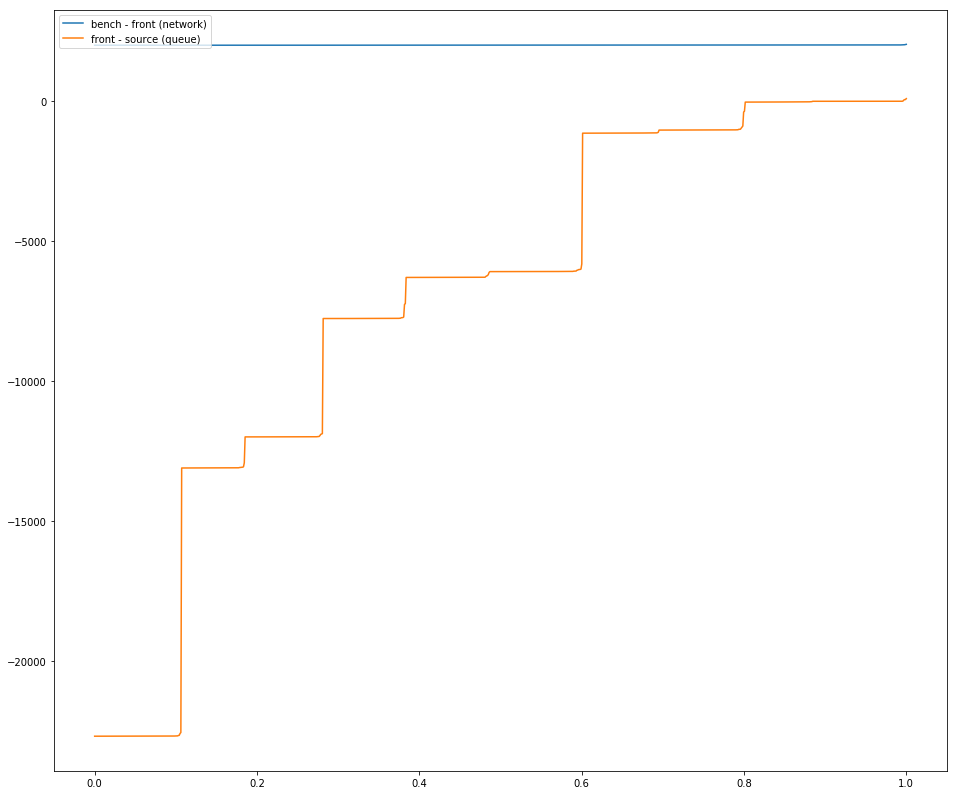

In [41]:
stage_plots(p)

# Acks

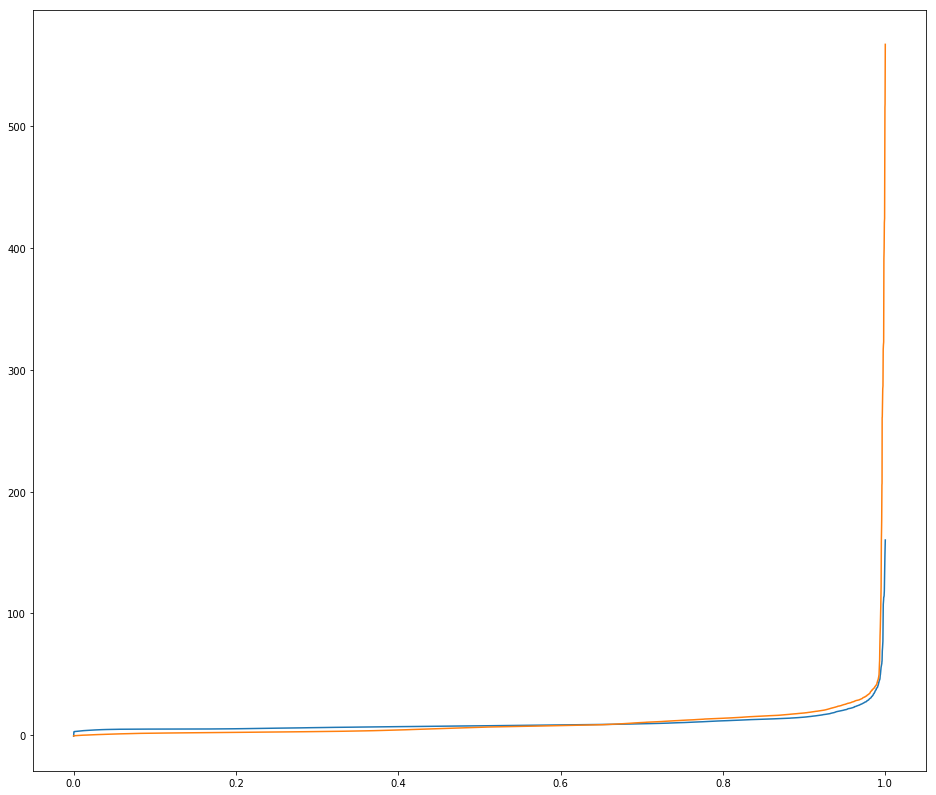

In [193]:
ack_acker_away = delay_between(acker_away, 'ack-create', 'ack-receive') + 5
ack_acker_same = delay_between(acker_same, 'ack-create', 'ack-receive') + 0

q1 = np.linspace(0, 1, np.size(ack_acker_away))
q2 = np.linspace(0, 1, np.size(ack_acker_same))

plt.plot(q1, np.sort(ack_acker_away), q2, np.sort(ack_acker_same))
plt.show()

In [191]:
pd.DataFrame(ack_acker_away).describe()

,0
count,6777.000000
mean,9.654799
std,8.796992
min,-0.819752
25%,5.780066
50%,7.711393
75%,10.325641
max,160.288821


In [192]:
pd.DataFrame(ack_acker_same).describe()

,0
count,6997.000000
mean,10.182313
std,25.922601
min,-0.619741
25%,2.643971
50%,6.552689
75%,12.221234
max,567.322296
